Inspired in https://maelfabien.github.io/machinelearning/NLP_5/#concept

More advanced techniques: https://joeddav.github.io/blog/2020/05/29/ZSL.html

Much more advance (FUTURE WORK): https://medium.com/swlh/few-shot-learning-in-nlp-use-siamese-networks-189de22459d0

In [1]:
%load_ext autoreload
%autoreload 2


In [3]:
import sys
import os
cwd = os.getcwd()
sys.path.insert(0, cwd + "/..")

In [4]:
from tqdm import tqdm
import matplotlib.pylab as plt
import numpy as np

# Loads a Dataset

In [5]:
from koala.utils import convert_to_samples

In [6]:
def balance_data(list_of_samples):
    labels, counts = np.unique([s.label for s in list_of_samples], return_counts=True)
    data_per_label = min(counts)
    counters = {l: 0 for l in labels}
    balanced_data = []
    for s in list_of_samples:
        if counters[s.label] == data_per_label:
            continue
        else:
            counters[s.label] = counters[s.label] + 1
            balanced_data.append(s)
    return balanced_data

In [164]:
from datasets import load_dataset
NAME_DATASET = "ag_news"
def change_label(sample, dict_names):
    sample.label = dict_names[sample.label]
    return sample

if NAME_DATASET == "ag_news":
    dict_names_labels = {0: "world",
                        1: "sports",
                        2: "business",
                        3: "science/tech"}
    
    datasets = load_dataset('ag_news')
    dataset_train = datasets["train"]
    dataset_test = datasets["test"]
    train_samples = convert_to_samples(dataset_train)
    test_samples = convert_to_samples(dataset_test)
    train_samples = [change_label(s, dict_names_labels) for s in train_samples]
    test_samples = [change_label(s, dict_names_labels) for s in test_samples]
elif NAME_DATASET == "per_sent":
    dict_names_labels = {0: "negative",
                        1: "neutral",
                        2: "positive"}
    
    datasets = load_dataset("per_sent")
    # We echange test and train because test is not balanced and it's too small to be balanced
    dataset_train = datasets["test_random"]
    dataset_test = datasets["train"]
    
    train_samples = convert_to_samples(dataset_train, 'DOCUMENT', 'TRUE_SENTIMENT')
    test_samples = convert_to_samples(dataset_test,  'DOCUMENT', 'TRUE_SENTIMENT')
    train_samples = [change_label(s, dict_names_labels) for s in train_samples]
    test_samples = [change_label(s, dict_names_labels) for s in test_samples]
    test_samples = balance_data(test_samples)
elif NAME_DATASET == "hate_speech_offensive":
    dict_names_labels = {0: "hate_speech",
                    1: "offensive",
                    2: "neither"}
    
    datasets = load_dataset("hate_speech_offensive")
    dataset_train = datasets["train"].filter(lambda example, indice: indice < 1000, with_indices=True)
    dataset_test = datasets["train"].filter(lambda example, indice: 1000< indice, with_indices=True)
    
    train_samples = convert_to_samples(dataset_train, 'tweet', 'class')
    test_samples = convert_to_samples(dataset_test,  'tweet', 'class')
    train_samples = [change_label(s, dict_names_labels) for s in train_samples]
    
    test_samples = [change_label(s, dict_names_labels) for s in test_samples]
    test_samples = balance_data(test_samples)
elif NAME_DATASET == "yahoo_answers_topics":
    datasets = load_dataset("yahoo_answers_topics")
    dataset_train = datasets["train"].filter(lambda example, indice: indice < 1000, with_indices=True)
    dataset_test = datasets["test"].filter(lambda example, indice: indice < 2000, with_indices=True)
    train_samples = convert_to_samples(dataset_train, "question_title", "topic")
    test_samples = convert_to_samples(dataset_test,"question_title", "topic")
    test_samples = balance_data(test_samples)



Using custom data configuration default
Reusing dataset ag_news (/home/rodri/.cache/huggingface/datasets/ag_news/default/0.0.0/fb5c5e74a110037311ef5e904583ce9f8b9fbc1354290f97b4929f01b3f48b1a)


In [165]:
print(len(train_samples), " for training")
print(len(test_samples), " for test")

120000  for training
7600  for test


In [166]:
labels = list(set([s.label for s in test_samples]))
print(labels)

['world', 'business', 'science/tech', 'sports']


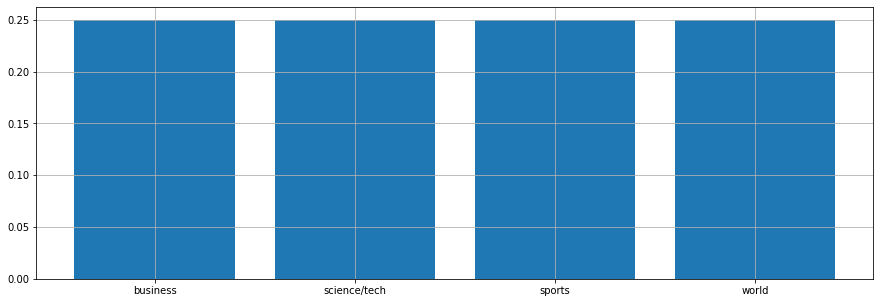

In [167]:

plt.figure(figsize=(15, 5))
labels, counts = np.unique([s.label for s in test_samples], return_counts=True)
norm_counts = counts / sum(counts)
plt.bar(labels, norm_counts);
plt.grid(True)

# Loads Encoder

In [168]:
from koala.encoders import Encoder

In [169]:
encoder = Encoder("en")

In [170]:
from tqdm import tqdm
for i in tqdm(range(len(test_samples))):
    s = test_samples[i]
    s.encode(encoder, keep_vector=True)
    test_samples[i] = s

100%|██████████| 7600/7600 [04:09<00:00, 30.46it/s]


# Visualization of the test data

In [171]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca = pca.fit([x.vector for x in test_samples])

In [172]:
reduced_vectors = pca.transform([x.vector for x in test_samples])

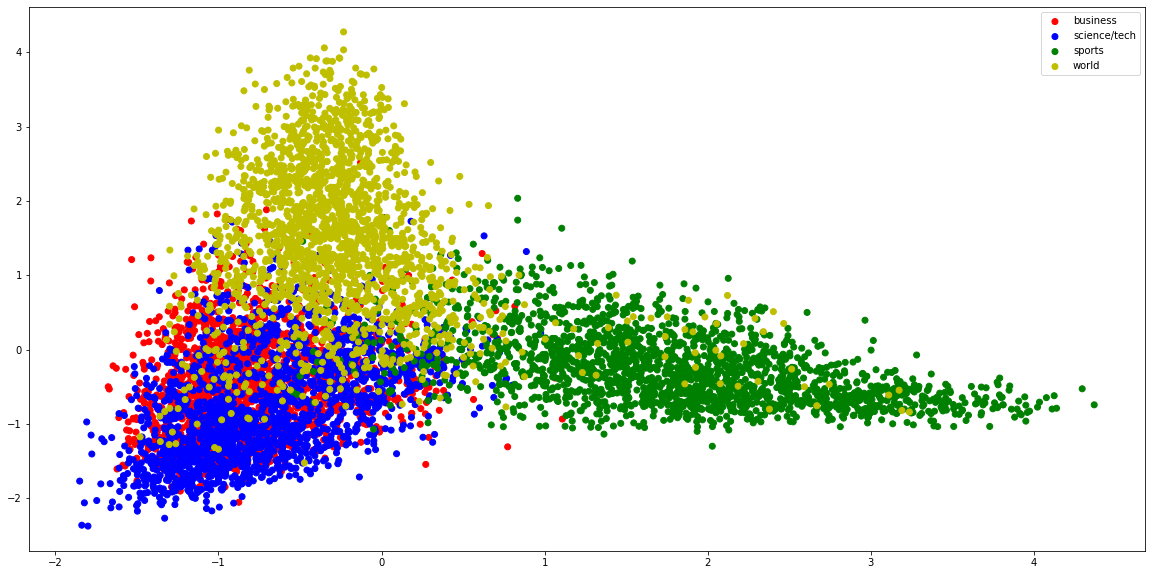

In [173]:

plt.figure(figsize=(20, 10))
colors = ["r", "b", "g", "y"]
for l in labels:
    vectors_to_plot = [reduced_vectors[i] for i in range(len(test_samples)) if test_samples[i].label == l]
    plt.scatter(*zip(*vectors_to_plot), c=[colors[list(labels).index(l)]] * len(vectors_to_plot))
plt.legend(labels);

# Dimensionality reduction

In [184]:
N = 180
pca = PCA(N)
pca = pca.fit([x.vector for x in test_samples])
print("Explained variance:", sum(pca.explained_variance_ratio_))

Explained variance: 0.9298613769270027


# Classification 

In [185]:
from koala.utils import split_samples_per_label
train_data_per_label = split_samples_per_label(train_samples)

In [186]:
samples_per_label = range(2, 50, 2)
max_samples_per_label = max(samples_per_label)

Limits to the maximum samples

In [187]:
for k, v in train_data_per_label.items():
    train_data_per_label[k] = v[:max_samples_per_label]

In [188]:
for k, v in train_data_per_label.items():
    print(k, ": ", v[0].text)

business :  Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
science/tech :  'Madden,' 'ESPN' Football Score in Different Ways (Reuters) Reuters - Was absenteeism a little high\on Tuesday among the guys at the office? EA Sports would like\to think it was because "Madden NFL 2005" came out that day,\and some fans of the football simulation are rabid enough to\take a sick day to play it.
sports :  Phelps, Thorpe Advance in 200 Freestyle (AP) AP - Michael Phelps took care of qualifying for the Olympic 200-meter freestyle semifinals Sunday, and then found out he had been added to the American team for the evening's 400 freestyle relay final. Phelps' rivals Ian Thorpe and Pieter van den Hoogenband and teammate Klete Keller were faster than the teenager in the 200 free preliminaries.
world :  Venezuelans Vote Early in Referendum on Chavez Rule (Reuters) Reuters - Venezuelans turned out early\and i

Encode training data

In [189]:
for k, v in train_data_per_label.items():
    for i in tqdm(range(len(v)), desc="Encoding label " + str(k)):
        v[i].encode(encoder, keep_vector=True)
    train_data_per_label[k] = v

Encoding label world: 100%|██████████| 48/48 [00:00<00:00, 48853.82it/s]


In [190]:
for n in samples_per_label:
    dict_vectors_per_label = {k: [x.vector for x in v] for k, v in train_data_per_label.items()}

In [191]:

def evaluate(classificator, dataset, name_experiment=""):
    dict_results = {}
    for d in tqdm(dataset, position=0, leave=True, desc="Evaluating " + name_experiment):
        r = classificator.classify_vector(d.vector)
        prediction = sorted(r.items(), key=lambda x: x[1], reverse=True)[0][0]
        l = d.label
        x = dict_results.get(l, {"ok": 0, "total": 0, "scores": []})
        if prediction == l:
            dict_results[l] = {"ok": x["ok"] + 1, "total": x["total"] +1, "scores": x["scores"] + [r[l]]}
        else:
            dict_results[l] = {"ok": x["ok"], "total": x["total"] +1, "scores": x["scores"] + [r[l]]}
    return dict_results

In [192]:
def compute_ratio(x):
    return x["ok"]/ x["total"]

def compute_accuracy(x):
    oks = sum([v["ok"] for v in x.values()])
    totals = sum([v["total"] for v in x.values()])
    return oks/totals

## Cosine distance to center

In [196]:
from koala.classifier import DistanceToAverageClassifier

In [197]:
results_cosine_distance_classifier = {}
for n in samples_per_label:
    dict_sampled = {k: v[:n] for k, v in dict_vectors_per_label.items()}
    distance_classifier = DistanceToAverageClassifier("cosine", True)
    distance_classifier.fit(dict_sampled)
    results_cosine_distance_classifier[n] = evaluate(distance_classifier, test_samples, str(n) + " samples per label")

Evaluating 48 samples per label: 100%|██████████| 7600/7600 [00:06<00:00, 1168.40it/s]


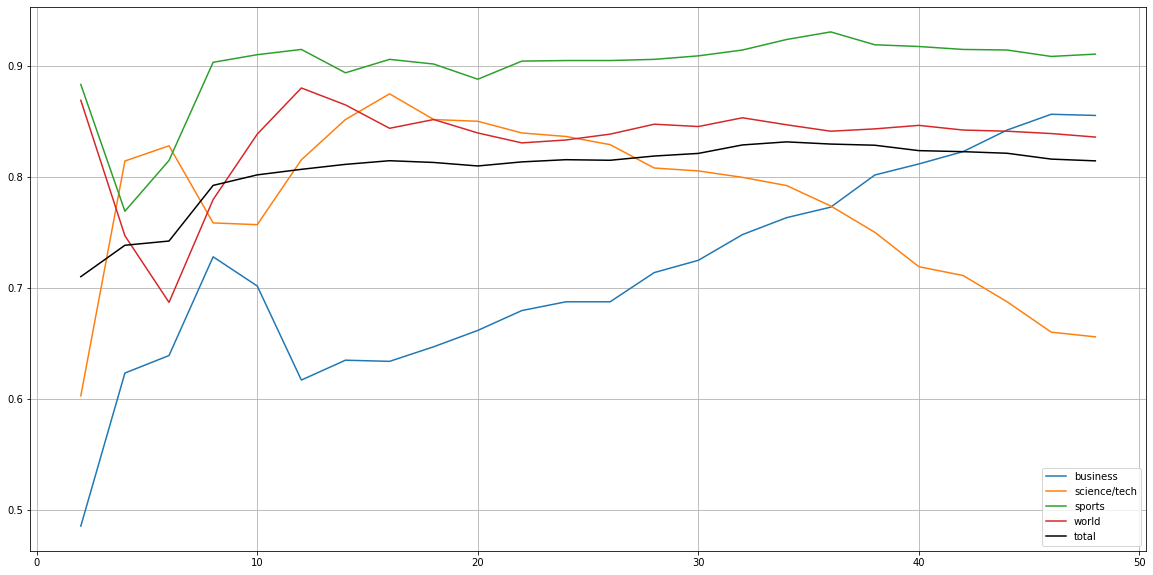

In [199]:
plt.figure(figsize=(20, 10))

        
    
for i in labels:
    r_i = sorted([(number_samples, compute_ratio(v[i])) for number_samples, v in results_cosine_distance_classifier.items()], key=lambda x: x[0])
    x, y = zip(*r_i) # unpack a list of pairs into two tuples

    plt.plot(x, y)
    
x, y = zip(*[(k, compute_accuracy(v)) for k, v in results_cosine_distance_classifier.items()])
plt.plot(x, y, c="k")

plt.legend(list(labels) + ["total"])
plt.grid(True)
plt.show()

## With K-neighbors

In [130]:
from koala.classifier import NeighborsClassifier

In [131]:
results_neighsbour_classifier = {}
for n in samples_per_label:
    dict_sampled = {k: v[:n] for k, v in dict_vectors_per_label.items()}
    neighbors_classifier = NeighborsClassifier()
    neighbors_classifier.fit(dict_sampled)
    results_neighsbour_classifier[n] = evaluate(neighbors_classifier, test_samples, str(n) + " samples per label")

Evaluating 48 samples per label: 100%|██████████| 1053/1053 [00:01<00:00, 617.81it/s]


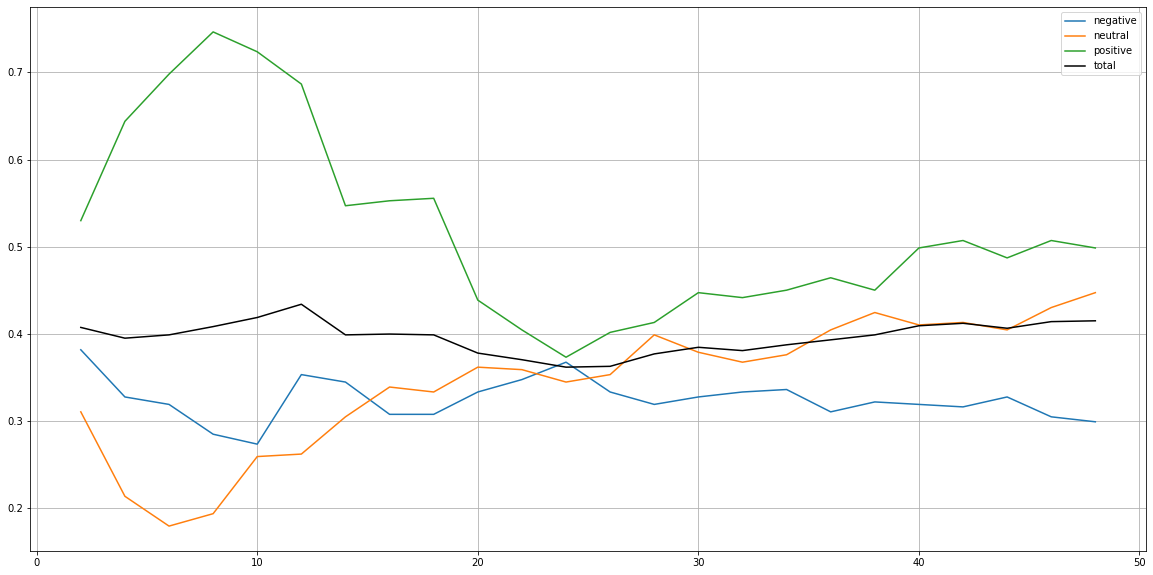

In [133]:
import matplotlib.pylab as plt
plt.figure(figsize=(20, 10))
def compute_ratio(x):
    return x["ok"]/ x["total"]

for i in dict_sampled.keys():
    r_i = sorted([(number_samples, compute_ratio(v[i])) for number_samples, v in results_neighsbour_classifier.items()], key=lambda x: x[0])
    x, y = zip(*r_i) # unpack a list of pairs into two tuples

    plt.plot(x, y)
x, y = zip(*[(k, compute_accuracy(v)) for k, v in results_neighsbour_classifier.items()])
plt.plot(x, y, c="k")

plt.legend(list(labels) + ["total"])
plt.grid(True)
plt.show()

 ## Similarity Classifier (Logistic)

In [139]:
from koala.classifier import SimilarityClassifier

In [144]:
results_similarity_classifier = {}
for n in samples_per_label:
    dict_sampled = {k: v[:n] for k, v in dict_vectors_per_label.items()}
    similarity_classifier = SimilarityClassifier()
    similarity_classifier.fit(dict_sampled)
    results_similarity_classifier[n] = evaluate(similarity_classifier, test_samples, str(n) + " samples per label")

Evaluating 48 samples per label: 100%|██████████| 1053/1053 [00:02<00:00, 396.08it/s]


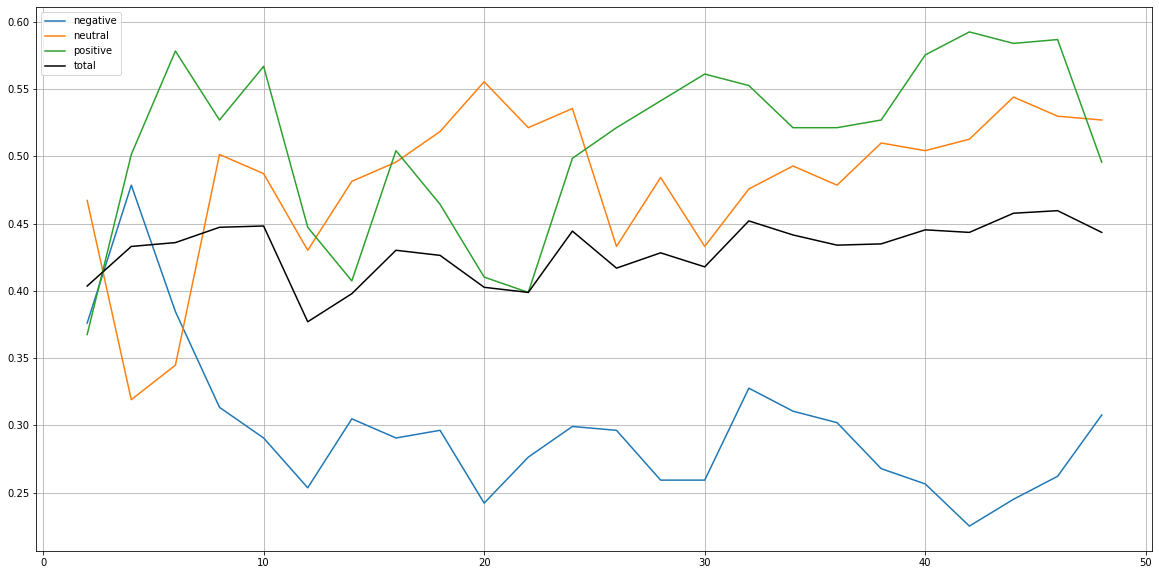

In [141]:
import matplotlib.pylab as plt
plt.figure(figsize=(20, 10))
def compute_ratio(x):
    return x["ok"]/ x["total"]

for i in dict_sampled.keys():
    r_i = sorted([(number_samples, compute_ratio(v[i])) for number_samples, v in results_similarity_classifier.items()], key=lambda x: x[0])
    x, y = zip(*r_i) # unpack a list of pairs into two tuples

    plt.plot(x, y)
x, y = zip(*[(k, compute_accuracy(v)) for k, v in results_similarity_classifier.items()])
plt.plot(x, y, c="k")

plt.legend(list(labels) + ["total"])
plt.grid(True)

## Similarity Classifier (Dense)

In [57]:
from koala.classifier import SimilarityClassifier

In [71]:
results_similarity_classifier_dense = {}
for n in samples_per_label:
    dict_sampled = {k: v[:n] for k, v in dict_vectors_per_label.items()}
    similarity_classifier = SimilarityClassifier("dense", pca)
    similarity_classifier.fit(dict_sampled)
    results_similarity_classifier_dense[n] = evaluate(similarity_classifier, test_samples, str(n) + " samples per label")

Evaluating 48 samples per label: 100%|██████████| 1053/1053 [00:47<00:00, 22.13it/s]


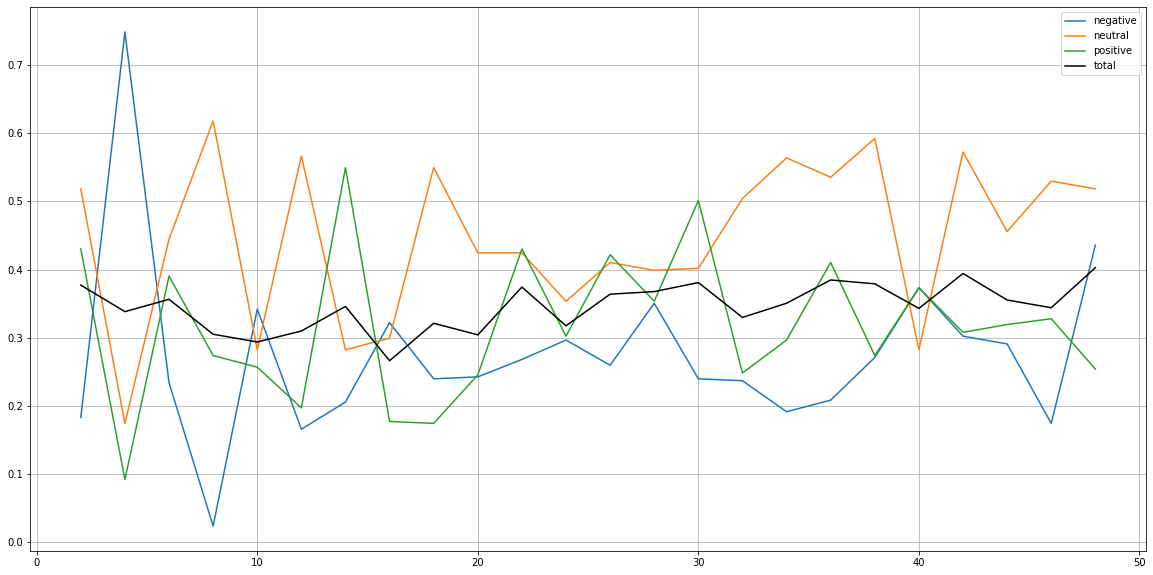

In [72]:
plt.figure(figsize=(20, 10))
def compute_ratio(x):
    return x["ok"]/ x["total"]

for i in dict_sampled.keys():
    r_i = sorted([(number_samples, compute_ratio(v[i])) for number_samples, v in results_similarity_classifier_dense.items()], key=lambda x: x[0])
    x, y = zip(*r_i) # unpack a list of pairs into two tuples

    plt.plot(x, y)
x, y = zip(*[(k, compute_accuracy(v)) for k, v in results_similarity_classifier_dense.items()])
plt.plot(x, y, c="k")

plt.legend(list(labels) + ["total"])
plt.grid(True)

## Siamese network

In [193]:
from koala.classifier import SiameseNetworkClassifier

In [ ]:
results_siamese_classifier = {}
for n in samples_per_label:
    dict_sampled = {k: v[:n] for k, v in dict_vectors_per_label.items()}
    siamese_classifier = SiameseNetworkClassifier(pca)
    siamese_classifier.fit(dict_sampled)
    results_siamese_classifier[n] = evaluate(siamese_classifier, test_samples, str(n) + " samples per label")

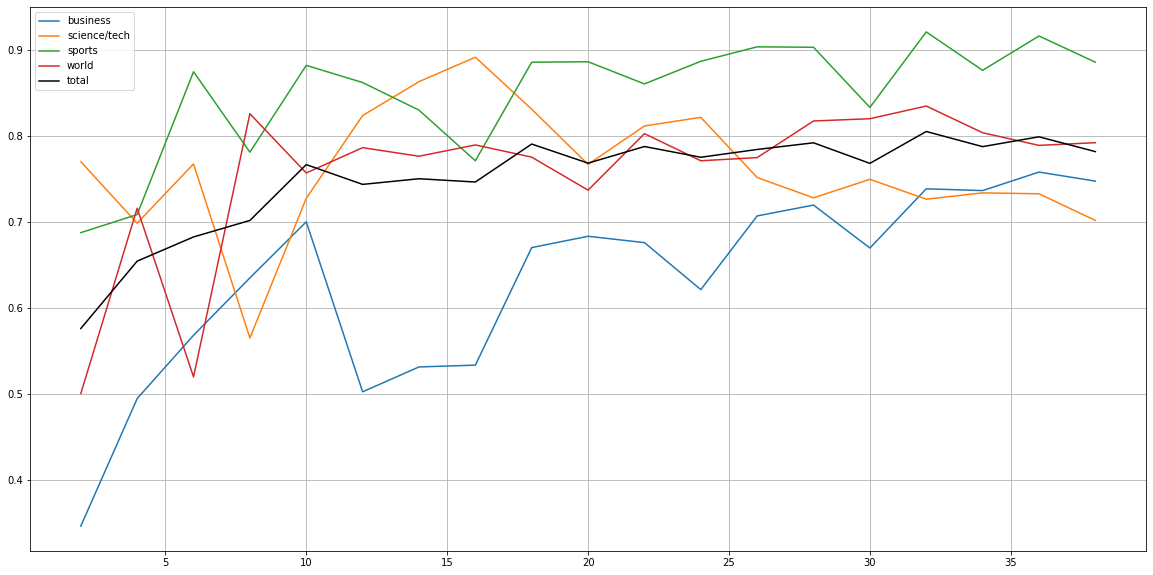

In [195]:
plt.figure(figsize=(20, 10))

for i in dict_sampled.keys():
    r_i = sorted([(number_samples, compute_ratio(v[i])) for number_samples, v in results_siamese_classifier.items()], key=lambda x: x[0])
    x, y = zip(*r_i) # unpack a list of pairs into two tuples

    plt.plot(x, y)
x, y = zip(*[(k, compute_accuracy(v)) for k, v in results_siamese_classifier.items()])
plt.plot(x, y, c="k")

plt.legend(list(labels) + ["total"])
plt.grid(True)

## Comparation of graphs

In [ ]:
legend_titles = []
colors = ["r", "b", "g", "y"]
plt.figure(figsize=(20, 10))
for idx, i in enumerate(dict_sampled.keys()):
        
    r_i = sorted([(number_samples, compute_ratio(v[i])) for number_samples, v in results_cosine_distance_classifier.items()], key=lambda x: x[0])
    x, y = zip(*r_i) # unpack a list of pairs into two tuples
    legend_titles.append("distance_cosine_" + str(i))
    plt.plot(x, y, c=colors[idx], marker="x")
    
    x, y = zip(*[(k, compute_accuracy(v)) for k, v in results_cosine_distance_classifier.items()])
    plt.plot(x, y, c="k", marker="x")
    legend_titles.append("distance_cosine_total")
    
    r_i = sorted([(number_samples, compute_ratio(v[i])) for number_samples, v in results_neighsbour_classifier.items()], key=lambda x: x[0])
    x, y = zip(*r_i) # unpack a list of pairs into two tuples
    legend_titles.append("neighbours_" + str(i))
    plt.plot(x, y, c=colors[idx], marker="o")
    
    x, y = zip(*[(k, compute_accuracy(v)) for k, v in results_neighsbour_classifier.items()])
    plt.plot(x, y, c="k", marker="o")
    legend_titles.append("distance_neighsbour")
    
    r_i = sorted([(number_samples, compute_ratio(v[i])) for number_samples, v in results_similarity_classifier.items()], key=lambda x: x[0])
    x, y = zip(*r_i) # unpack a list of pairs into two tuples
    legend_titles.append("similarity_" + str(i))
    plt.plot(x, y, c=colors[idx], marker="s")
    
    x, y = zip(*[(k, compute_accuracy(v)) for k, v in results_similarity_classifier.items()])
    plt.plot(x, y, c="k", marker="s")
    legend_titles.append("distance_similarity_total")
    
plt.legend(legend_titles)
plt.grid(True)

## Merge of classifiers

In [65]:
from koala.classifier import MultiClassifier

In [66]:
results_muticlassifier = {}
for n in samples_per_label:
    dict_sampled = {k: v[:n] for k, v in dict_vectors_per_label.items()}
    neighbors_classifier = MultiClassifier()
    neighbors_classifier.fit(dict_sampled)
    results_muticlassifier[n] = evaluate(neighbors_classifier, test_samples, str(n) + " samples per label")

Evaluating 48 samples per label: 100%|██████████| 7600/7600 [00:21<00:00, 345.57it/s]


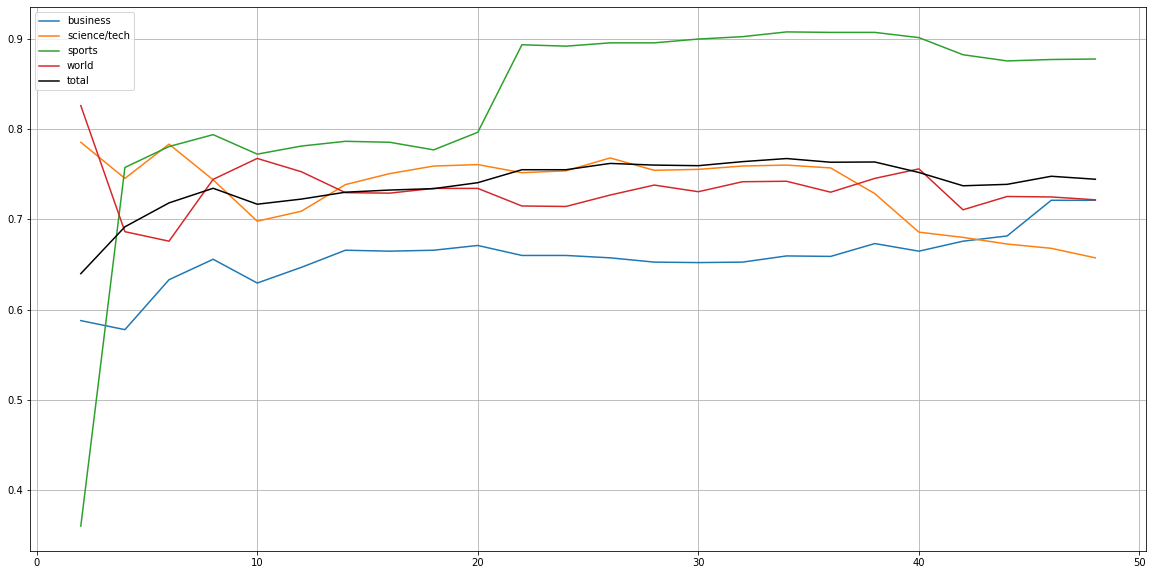

In [67]:
import matplotlib.pylab as plt
plt.figure(figsize=(20, 10))
def compute_ratio(x):
    return x["ok"]/ x["total"]

for i in dict_sampled.keys():
    r_i = sorted([(number_samples, compute_ratio(v[i])) for number_samples, v in results_muticlassifier.items()], key=lambda x: x[0])
    x, y = zip(*r_i) # unpack a list of pairs into two tuples

    plt.plot(x, y)
    

x, y = zip(*[(k, compute_accuracy(v)) for k, v in results_muticlassifier.items()])
plt.plot(x, y, c="k")

plt.legend(list(labels) + ["total"])
plt.grid(True)
plt.grid(True)
plt.show()

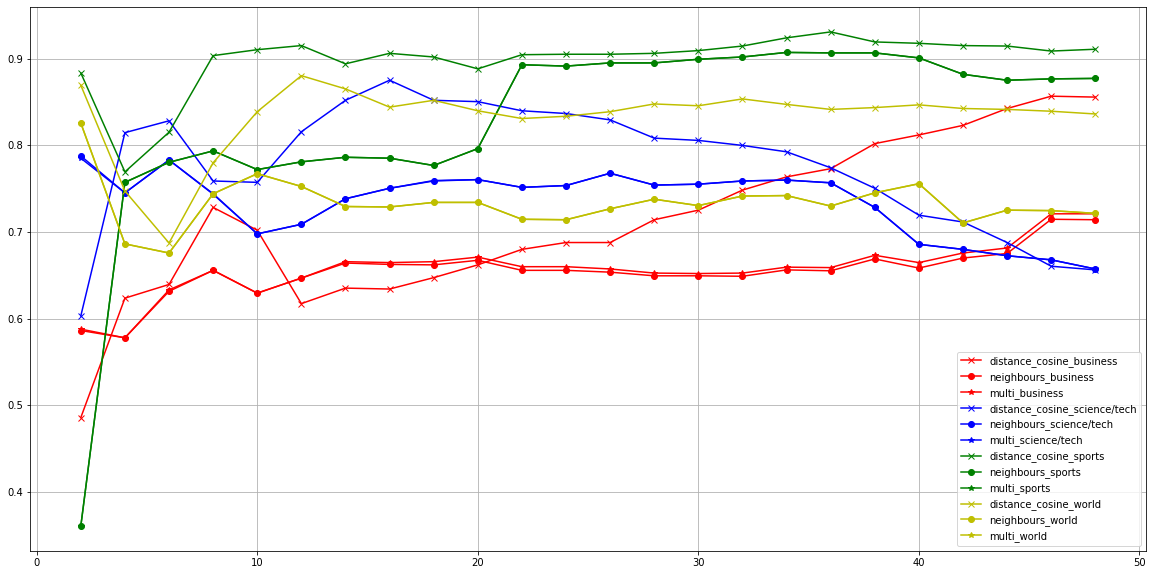

In [68]:
legend_titles = []
colors = ["r", "b", "g", "y"]
plt.figure(figsize=(20, 10))
for idx, i in enumerate(dict_sampled.keys()):
        
    r_i = sorted([(number_samples, compute_ratio(v[i])) for number_samples, v in results_cosine_distance_classifier.items()], key=lambda x: x[0])
    x, y = zip(*r_i) # unpack a list of pairs into two tuples
    legend_titles.append("distance_cosine_" + str(i))
    plt.plot(x, y, c=colors[idx], marker="x")
    
    r_i = sorted([(number_samples, compute_ratio(v[i])) for number_samples, v in results_neighsbour_classifier.items()], key=lambda x: x[0])
    x, y = zip(*r_i) # unpack a list of pairs into two tuples
    legend_titles.append("neighbours_" + str(i))
    plt.plot(x, y, c=colors[idx], marker="o")
    
    r_i = sorted([(number_samples, compute_ratio(v[i])) for number_samples, v in results_muticlassifier.items()], key=lambda x: x[0])
    x, y = zip(*r_i) # unpack a list of pairs into two tuples
    legend_titles.append("multi_" + str(i))
    plt.plot(x, y, c=colors[idx], marker="*")
    

    
plt.legend(legend_titles)
plt.grid(True)